# Student Performance in Highschool 

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, t

In [2]:
df_mat = pd.read_csv('student-mat.csv', sep=';')
df_por = pd.read_csv('student-por.csv', sep=';')

In [3]:
df_mat.shape

(395, 33)

In [4]:
df_por.shape

(649, 33)

In [5]:
df_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


# Data Cleaning

## Merging DataFrames

In [6]:
df = df_mat.merge(df_por, on=["school","sex","age",
                              "address","famsize","Pstatus",
                              "Medu","Fedu","Mjob",
                              "Fjob","reason","nursery",
                              "internet"
                             ], how='inner')

# Count how many values differ from df_mat and df_por
for column in df.columns:
    if column.endswith('_x'):
        diff_values = (df[column] != df[column[:-2]+'_y']).sum()
        print(f' {column} vs {column[:-2]}_y : {diff_values}')

 guardian_x vs guardian_y : 6
 traveltime_x vs traveltime_y : 5
 studytime_x vs studytime_y : 9
 failures_x vs failures_y : 53
 schoolsup_x vs schoolsup_y : 3
 famsup_x vs famsup_y : 5
 paid_x vs paid_y : 171
 activities_x vs activities_y : 5
 higher_x vs higher_y : 4
 romantic_x vs romantic_y : 6
 famrel_x vs famrel_y : 10
 freetime_x vs freetime_y : 11
 goout_x vs goout_y : 10
 Dalc_x vs Dalc_y : 5
 Walc_x vs Walc_y : 12
 health_x vs health_y : 8
 absences_x vs absences_y : 280
 G1_x vs G1_y : 335
 G2_x vs G2_y : 336
 G3_x vs G3_y : 344


In [7]:
"""Merge all columns, but absences, failures, 
extra paid classes and grades, because they are specific variables of maths and portugese."""


col_to_be_merged = list(df_mat.columns)
col_to_be_merged.remove('paid')
col_to_be_merged.remove('absences')
col_to_be_merged.remove('failures')
col_to_be_merged.remove('G1')
col_to_be_merged.remove('G2')
col_to_be_merged.remove('G3')


df = df_mat.merge(df_por, on=col_to_be_merged, how='inner')

In [8]:
# Re-order columns
df = df[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'failures_x', 'failures_y',
       'paid_x', 'paid_y', 'absences_x', 'absences_y', 'G1_x', 'G2_x', 'G3_x', 'G1_y', 'G2_y', 'G3_y']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 369
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      370 non-null    object
 1   sex         370 non-null    object
 2   age         370 non-null    int64 
 3   address     370 non-null    object
 4   famsize     370 non-null    object
 5   Pstatus     370 non-null    object
 6   Medu        370 non-null    int64 
 7   Fedu        370 non-null    int64 
 8   Mjob        370 non-null    object
 9   Fjob        370 non-null    object
 10  reason      370 non-null    object
 11  guardian    370 non-null    object
 12  traveltime  370 non-null    int64 
 13  studytime   370 non-null    int64 
 14  schoolsup   370 non-null    object
 15  famsup      370 non-null    object
 16  activities  370 non-null    object
 17  nursery     370 non-null    object
 18  higher      370 non-null    object
 19  internet    370 non-null    object
 20  romantic  

In [10]:
# Check the missing values 

df.isna().sum()
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
schoolsup     0
famsup        0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
failures_x    0
failures_y    0
paid_x        0
paid_y        0
absences_x    0
absences_y    0
G1_x          0
G2_x          0
G3_x          0
G1_y          0
G2_y          0
G3_y          0
dtype: int64

In [11]:
# Rename x by math and y by portugese
df.rename(columns={'paid_x': 'paid_mat', 
                   'paid_y': 'paid_por', 
                   'absences_x': 'absences_mat', 
                   'absences_y':'absences_por',
                   'failures_x':'failures_mat',
                   'failures_y':'failures_por',
                   'G1_y':'G1_por',
                   'G2_y':'G2_por',
                   'G3_y':'G3_por',
                   'G1_x':'G1_mat',
                   'G2_x':'G2_mat',
                   'G3_x':'G3_mat',
                  }, inplace=True)

In [12]:
# Get the mean of average grades in each subject

df['mat_mean'] = round((df['G1_mat'] + df['G2_mat'] + df['G3_mat'])/3, 2)
df['por_mean'] = round((df['G1_por'] + df['G2_por'] + df['G3_por'])/3, 2)

# Add females and males average grades 

df['females'] = df[df["sex"] == 'F'].mat_mean
df['males'] = df[df["sex"] == 'M'].mat_mean

In [13]:
# Drop features with grades since they will be sources of multicolinearity 

df.drop(
    ['G1_por', 'G2_por', 'G3_por', 'G1_mat', 'G2_mat', 'G3_mat'], 
        axis=1, inplace=True)

In [14]:
df.loc[56]

school                  GP
sex                      F
age                     15
address                  U
famsize                GT3
Pstatus                  A
Medu                     4
Fedu                     3
Mjob              services
Fjob              services
reason          reputation
guardian            mother
traveltime               1
studytime                2
schoolsup               no
famsup                 yes
activities             yes
nursery                yes
higher                 yes
internet               yes
romantic                no
famrel                   4
freetime                 3
goout                    2
Dalc                     1
Walc                     1
health                   1
failures_mat             0
failures_por             0
paid_mat               yes
paid_por                no
absences_mat             0
absences_por             0
mat_mean             14.67
por_mean             14.67
females              14.67
males                  NaN
N

# Descriptive Statistics

In [15]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,failures_mat,failures_por,absences_mat,absences_por,mat_mean,por_mean,females,males
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,195.000000,175.000000
mean,16.575676,2.800000,2.556757,1.445946,2.043243,3.935135,3.224324,3.116216,1.483784,2.294595,3.562162,0.278378,0.132432,5.381081,3.632432,10.702486,12.319892,10.237231,11.220914
std,1.180672,1.083505,1.086138,0.701178,0.847934,0.911301,0.985506,1.128592,0.896247,1.290878,1.407558,0.710599,0.489762,7.665653,4.827656,3.730804,2.530410,3.667891,3.742322
min,15.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.330000,4.000000,1.330000,1.670000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,8.330000,10.670000,8.000000,9.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,0.000000,0.000000,4.000000,2.000000,10.670000,12.330000,10.000000,11.330000
75%,17.000000,4.000000,3.750000,2.000000,2.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,0.000000,0.000000,8.000000,6.000000,13.330000,14.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,75.000000,32.000000,19.330000,18.670000,18.670000,19.330000


In [16]:
# Check the no. of unique items present in the categorical column

df.select_dtypes('object').nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
activities    2
nursery       2
higher        2
internet      2
romantic      2
paid_mat      2
paid_por      2
dtype: int64

In [17]:
# Check the percentage of missing values in each column present in the dataset

df.isnull().sum()/df.shape[0]

school          0.000000
sex             0.000000
age             0.000000
address         0.000000
famsize         0.000000
Pstatus         0.000000
Medu            0.000000
Fedu            0.000000
Mjob            0.000000
Fjob            0.000000
reason          0.000000
guardian        0.000000
traveltime      0.000000
studytime       0.000000
schoolsup       0.000000
famsup          0.000000
activities      0.000000
nursery         0.000000
higher          0.000000
internet        0.000000
romantic        0.000000
famrel          0.000000
freetime        0.000000
goout           0.000000
Dalc            0.000000
Walc            0.000000
health          0.000000
failures_mat    0.000000
failures_por    0.000000
paid_mat        0.000000
paid_por        0.000000
absences_mat    0.000000
absences_por    0.000000
mat_mean        0.000000
por_mean        0.000000
females         0.472973
males           0.527027
dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='mat_mean'>

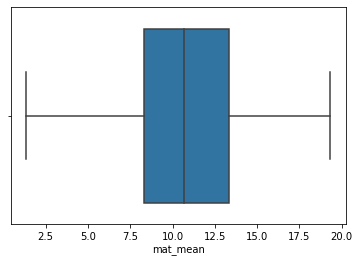

In [18]:
# Let's check for outliers in mat_mean

sns.boxplot(df.mat_mean)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='mat_mean'>

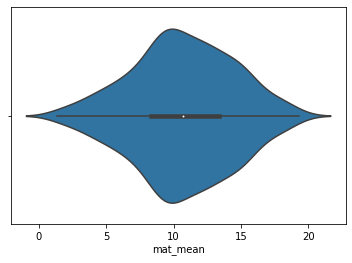

In [19]:
sns.violinplot(df.mat_mean)

In [20]:
df.mat_mean.mean()

10.702486486486487

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age distribution')

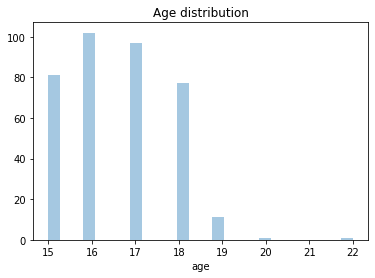

In [21]:
# Let's check for outliers in age distribution

sns.distplot(df.age, kde=False)
plt.title('Age distribution')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='age'>

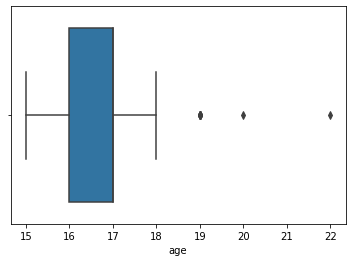

In [22]:
# Let's check for outliers - boxplot

sns.boxplot(df.age)

In [23]:
# Let's remove the two outliers 20 and 22 since there are only one data for each value

df = df.loc[(df.age != 20) & (df.age != 22)]
df = df.loc[(df.age != 20) & (df.age != 22)]

# Data Exploration

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


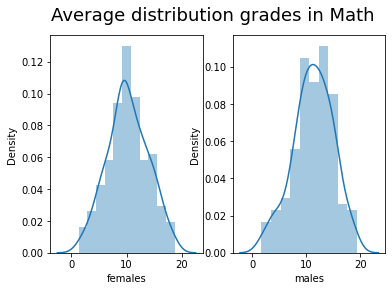

In [24]:
plt.subplot(1, 2, 1)
sns.distplot(df.females)

plt.subplot(1, 2, 2)
sns.distplot(df.males)

plt.suptitle('Average distribution grades in Math', fontsize = 18)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


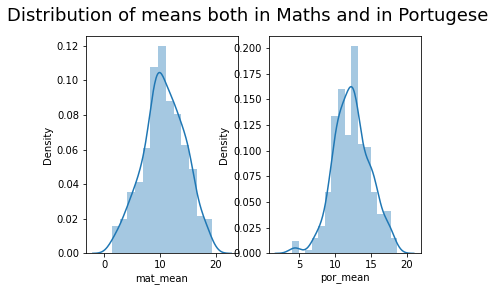

In [25]:
plt.subplot(1, 2, 1)
sns.distplot(df.mat_mean)

plt.subplot(1, 2, 2)
sns.distplot(df.por_mean)

plt.suptitle('Distribution of means both in Maths and in Portugese', fontsize = 18)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The pearson correlation coeff btw mean in maths and mean in portugese is 0.5957871430352336


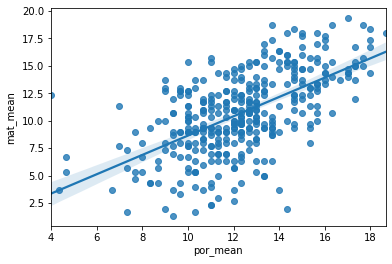

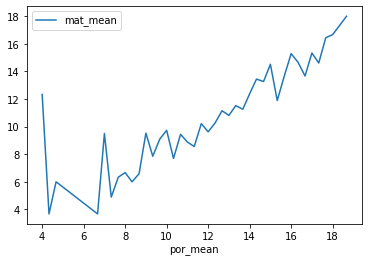

In [26]:
# Correlation btw maths and portugese's results 

sns.regplot(df.por_mean, df.mat_mean)

df[['por_mean', 'mat_mean']].groupby('por_mean').mean().plot()

print('The pearson correlation coeff btw mean in maths and mean in portugese is', np.corrcoef(
    df.mat_mean, df.por_mean)[0][1])

Text(0.5, 1.0, 'Gabriel Pereira vs Mousinho da Silveira')

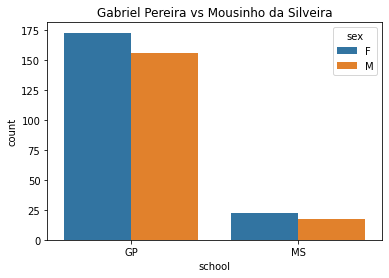

In [27]:
ax = sns.countplot(x=df.school, hue="sex", data=df)
plt.title("Gabriel Pereira vs Mousinho da Silveira")

Text(0.5, 1.0, 'Gabriel Pereira vs Mousinho da Silveira')

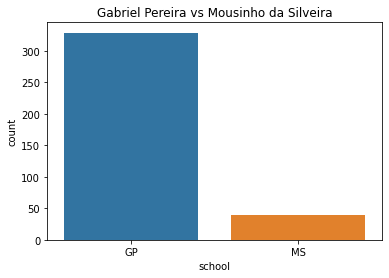

In [28]:
ax = sns.countplot(x=df.school, data=df)
plt.title("Gabriel Pereira vs Mousinho da Silveira")

Text(0.5, 1.0, 'Females and Males')

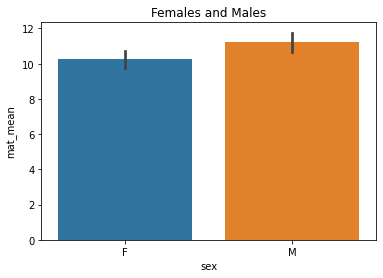

In [29]:
sns.barplot(x=df.sex, y=df.mat_mean)
plt.title("Females and Males")

Text(0.5, 1.0, 'Age and average in Math')

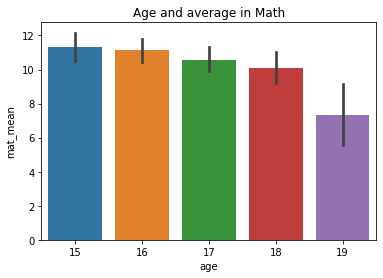

In [30]:
sns.barplot(x=df.age, y=df.mat_mean)
plt.title("Age and average in Math")

The pearson correlation coeff btw mean in maths and mean in portugese is 0.11667552042816602


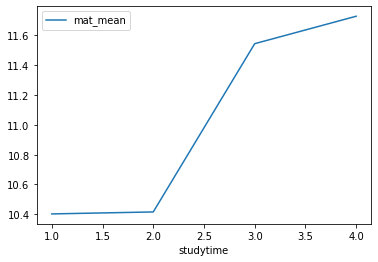

In [31]:
df[['studytime', 'mat_mean']].groupby('studytime').mean().plot()
print('The pearson correlation coeff btw mean in maths and mean in portugese is', np.corrcoef(df.studytime, df.mat_mean)[0][1])

,mat_mean
traveltime,
1,10.998250
2,10.366970
3,9.555714
4,8.542500


The pearson correlation coeff btw traveltime and mean in maths is -0.13729523840036933


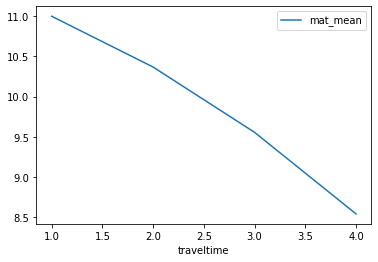

In [32]:
display(df[['traveltime', 'mat_mean']].groupby('traveltime').mean())
df[['traveltime', 'mat_mean']].groupby('traveltime').mean().plot()
print('The pearson correlation coeff btw traveltime and mean in maths is', np.corrcoef(df.traveltime, df.mat_mean)[0][1])

Text(0.5, 1.0, 'Failures in mathematics')

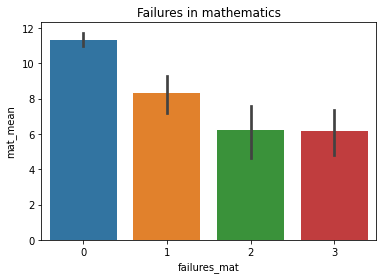

In [33]:
ax = sns.barplot(x=df.failures_mat,y=df.mat_mean, data=df)
plt.title("Failures in mathematics")

[Text(0.5, 0, 'Address')]

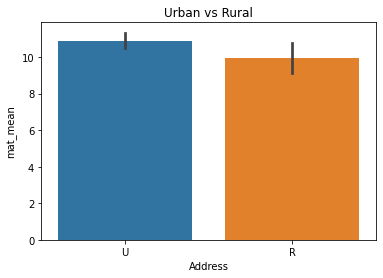

In [34]:
ax = sns.barplot(x=df.address, y=df.mat_mean)
plt.title("Urban vs Rural")
ax.set(xlabel='Address')

[Text(0.5, 0, 'Number of children')]

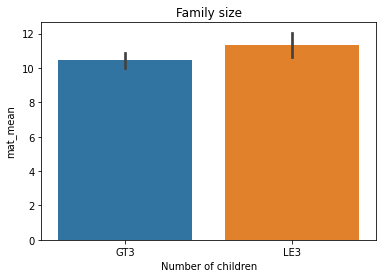

In [35]:
ax = sns.barplot(x=df.famsize, y=df.mat_mean)
plt.title("Family size")
ax.set(xlabel='Number of children')

[Text(0.5, 0, 'Marital status')]

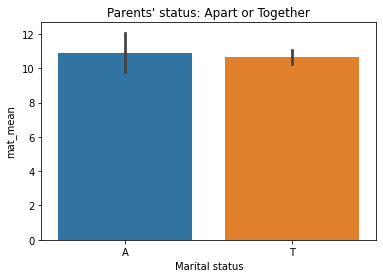

In [36]:
ax = sns.barplot(x=df.Pstatus, y=df.mat_mean)
plt.title("Parents' status: Apart or Together")
ax.set(xlabel='Marital status')

[Text(0.5, 0, 'Level of education')]

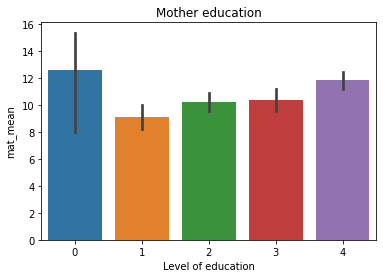

In [37]:
ax = sns.barplot(x=df.Medu, y=df.mat_mean)
plt.title("Mother education")
ax.set(xlabel='Level of education')

[Text(0.5, 0, 'Level of education')]

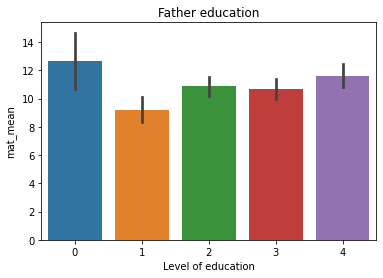

In [38]:
ax = sns.barplot(x=df.Fedu, y=df.mat_mean)
plt.title("Father education")
ax.set(xlabel='Level of education')

[Text(0.5, 0, 'Activity')]

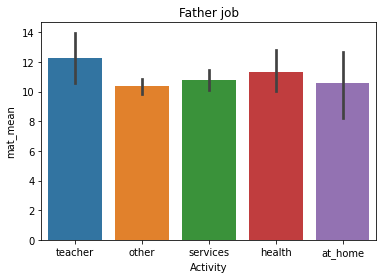

In [39]:
ax = sns.barplot(x=df.Fjob, y=df.mat_mean)
plt.title("Father job")
ax.set(xlabel='Activity')

[Text(0.5, 0, 'Activity')]

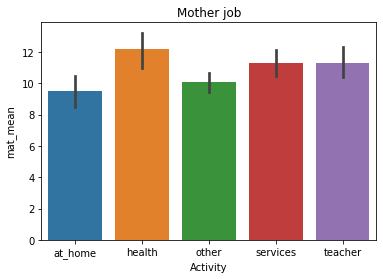

In [40]:
ax = sns.barplot(x=df.Mjob, y=df.mat_mean)
plt.title("Mother job")
ax.set(xlabel='Activity')

Text(0.5, 1.0, 'Extra paid classes')

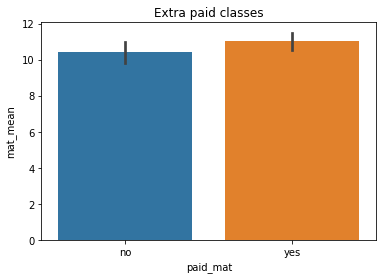

In [41]:
ax = sns.barplot(x=df.paid_mat, y=df.mat_mean)
plt.title("Extra paid classes")

Text(0.5, 1.0, 'Family support')

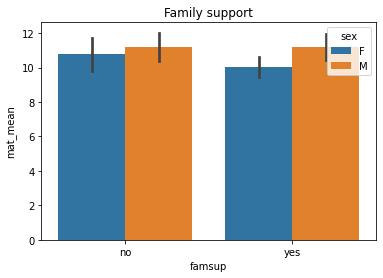

In [42]:
ax = sns.barplot(x=df.famsup, y=df.mat_mean, hue=df.sex)
plt.title("Family support")

Text(0.5, 1.0, 'Have internet at home')

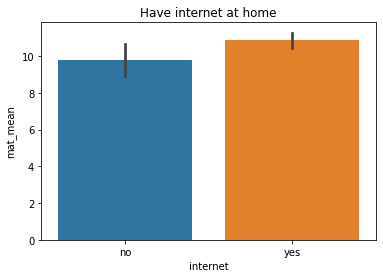

In [43]:
ax = sns.barplot(x=df.internet, y=df.mat_mean)
plt.title("Have internet at home")

Text(0.5, 1.0, 'Attended nursery school')

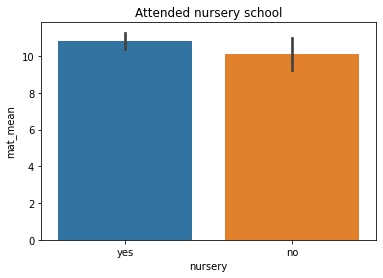

In [44]:
ax = sns.barplot(x=df.nursery, y=df.mat_mean)
plt.title("Attended nursery school")

Text(0.5, 1.0, 'Extra School Activities')

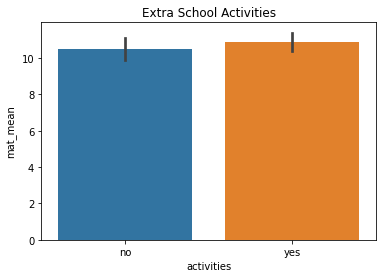

In [45]:
ax = sns.barplot(x=df.activities, y=df.mat_mean)
plt.title("Extra School Activities")

Text(0.5, 1.0, 'Go out with friends')

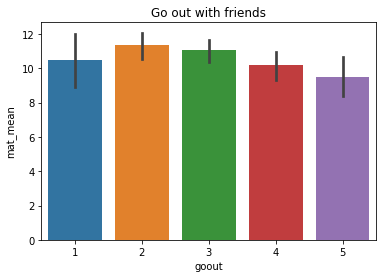

In [46]:
ax = sns.barplot(x=df.goout, y=df.mat_mean)
plt.title("Go out with friends")

Text(0.5, 1.0, 'Drink alcohol during the week')

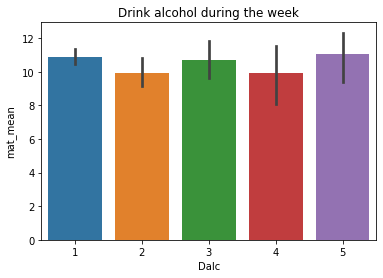

In [47]:
ax = sns.barplot(x=df.Dalc, y=df.mat_mean)
plt.title("Drink alcohol during the week")

In [48]:
df.drop('Dalc', axis=1, inplace=True)

Text(0.5, 1.0, 'Drink alcohol during the week-end')

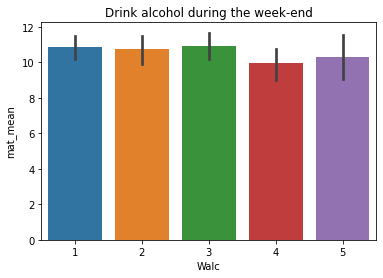

In [49]:
ax = sns.barplot(x=df.Walc, y=df.mat_mean)
plt.title("Drink alcohol during the week-end")

In [50]:
df.drop('Walc', axis=1, inplace=True)

Text(0.5, 1.0, 'Have a romantic relationship')

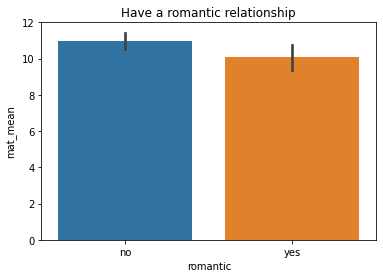

In [51]:
ax = sns.barplot(x=df.romantic, y=df.mat_mean)
plt.title("Have a romantic relationship")

<AxesSubplot:xlabel='absences_mat', ylabel='mat_mean'>

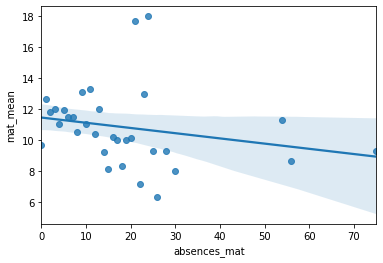

In [52]:
df_grouped_abs = df[['absences_mat', 'mat_mean']].groupby('absences_mat').mean()
sns.regplot(x=df_grouped_abs.index, y=df_grouped_abs['mat_mean'])

Text(0.5, 1.0, 'Have good family relationships')

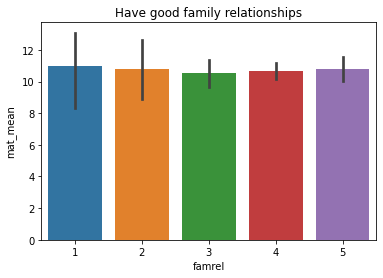

In [53]:
ax = sns.barplot(x=df.famrel, y=df.mat_mean)
plt.title("Have good family relationships")

In [54]:
df.drop('famrel', axis=1, inplace=True)

Text(0.5, 1.0, 'Want to take higher education')

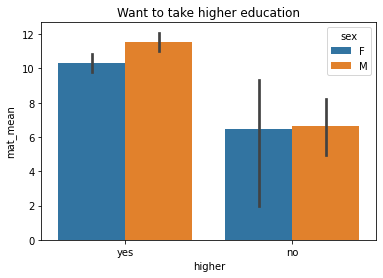

In [55]:
ax = sns.barplot(x=df.higher, y=df.mat_mean, hue=df.sex)
plt.title("Want to take higher education")

In [56]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'schoolsup', 'famsup', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'freetime', 'goout', 'health', 'failures_mat',
       'failures_por', 'paid_mat', 'paid_por', 'absences_mat', 'absences_por',
       'mat_mean', 'por_mean', 'females', 'males'],
      dtype='object')

# Inferential Statistics

## Hypothesis Testing 

### Are highschool boys in Portugal significantly better in maths than girls, on average ? 

Population: All highschool students in Portugal 

Parameter of Interest:  𝜇_m mean of boys in maths ; 𝜇_f mean of girls in maths. 

Null Hypothesis:  𝜇_m = 𝜇_f

Alternative Hypthosis:  𝜇_m > 𝜇_f

Data:
Df
Statistics on population are unknown.

### Assumptions: 
- The observations of the grades and means in the dataset are considered to be the realizations of random variables independent and identically distributed. 
- Therefore they are normally distributed following a normal law with parameters 𝜇_m (males) and 𝜇_f (females).

### Choice of test:

We will use a t-test, since we compare two samples of normally distributed data, with unknown parameters.


### Descriptive statistics on our samples:

In [57]:
# Sizes of samples
print('The sizes of the two samples are:')
display(df[['mat_mean', 'sex']].groupby('sex').count())
sizes = df[['mat_mean', 'sex']].groupby('sex').count()

# Means of samples
print('\nThe means of the two samples are:')
display(df[['mat_mean', 'sex']].groupby('sex').mean())
means = df[['mat_mean', 'sex']].groupby('sex').mean()

# Std of samples
print('\nThe std of the two samples are:')
display(df[['mat_mean', 'sex']].groupby('sex').std())
stds = df[['mat_mean', 'sex']].groupby('sex').std()

The sizes of the two samples are:


,mat_mean
sex,
F,195
M,173



The means of the two samples are:


,mat_mean
sex,
F,10.237231
M,11.206127



The std of the two samples are:


,mat_mean
sex,
F,3.667891
M,3.719916


### Running the test

In [58]:
females = df[df["sex"] == 'F'].mat_mean
males = df[df["sex"] == 'M'].mat_mean

ttest_ind(females, males, equal_var=False)

Ttest_indResult(statistic=-2.5102368257299608, pvalue=0.012503496706226622)

### Conclusion on the test:

Since the p-value is significantly lower than 5%, we can reject the null hypothesis of equal means btw boys and girls with certainty 95%. Therefore we can say that it may be possible that male highschool students in Portugal get higher grades than female students in mathematics.

## Confidence Intervals

In [59]:
# For the Portuguese girls' mean in maths:

# i is either 0 for females and 1 for males 
def ci_norm(x, i):
    sample_mean = x.mean()
    standard_error = (stds['mat_mean'][i])/(x.shape[0])**0.5
    return norm.interval(0.95, scale=standard_error)

sample_mean_f = means['mat_mean'][0]
sample_mean_m = means['mat_mean'][1]

ci_females = ci_norm(females, 0)
print(f'The mean of highschool girls in Portugal falls btw {round(ci_females[0]+sample_mean_f, 1)} and {round(ci_females[1]+sample_mean_f, 1)} with certainty 95%.')

ci_males = ci_norm(males, 1)
print(f'The mean of highschool boys in Portugal falls btw {round(ci_males[0]+sample_mean_m, 1)} and {round(ci_males[1]+sample_mean_m, 1)}  with certainty 95%.')


The mean of highschool girls in Portugal falls btw 9.7 and 10.8 with certainty 95%.
The mean of highschool boys in Portugal falls btw 10.7 and 11.8  with certainty 95%.


# Linear Regression Model

In [60]:
dummies = []

In [61]:
dummies.append('school')
dummies.append('sex')
dummies.append('address')
dummies.append('famsize')
dummies.append('Pstatus')
dummies.append('famsup')
dummies.append('activities')
dummies.append('nursery')
dummies.append('higher')
dummies.append('internet')
dummies.append('romantic')
dummies.append('paid_mat')


dummies.append('Mjob')
dummies.append('Fjob')
dummies.append('reason')
dummies.append('guardian')
dummies.append('schoolsup')
dummies.append('paid_por')

In [62]:
df1 = pd.get_dummies(data=df, columns=dummies, drop_first=True)

In [63]:
df1.columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'freetime', 'goout',
       'health', 'failures_mat', 'failures_por', 'absences_mat',
       'absences_por', 'mat_mean', 'por_mean', 'females', 'males', 'school_MS',
       'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'famsup_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes', 'paid_mat_yes', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other',
       'reason_reputation', 'guardian_mother', 'guardian_other',
       'schoolsup_yes', 'paid_por_yes'],
      dtype='object')

<AxesSubplot:>

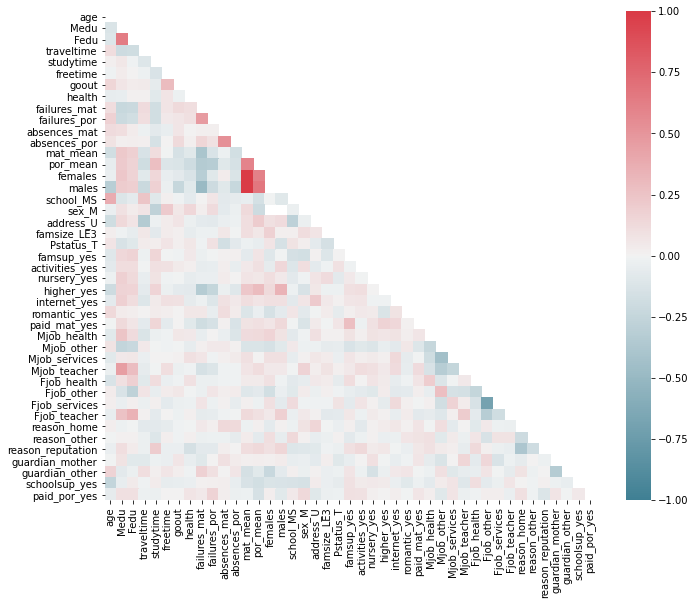

In [64]:
corr= df1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap=cmap, center=0)

# OLS method for Linear Regression Model

In [65]:
from statsmodels.api import OLS
from statsmodels.api import add_constant

In [66]:
df1.drop(['females', 'males'], axis=1, inplace=True)

In [67]:
y=df1.mat_mean
X=df1.drop('mat_mean', axis=1).drop(['Pstatus_T', 'Medu', 'Fedu', 'traveltime', 'studytime', 'freetime', 'goout', 'health', 'higher_yes', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'reason_other', 'reason_home', 'guardian_mother', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'guardian_other', 'paid_por_yes', 'schoolsup_yes', 'address_U', 'famsize_LE3', 'paid_mat_yes', 'activities_yes', 'nursery_yes', 'reason_reputation', 'romantic_yes', 'internet_yes', 'failures_por', 'absences_por', 'Fjob_teacher'], axis=1)
model=OLS(y,add_constant(X))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               mat_mean   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     44.56
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.19e-49
Time:                        14:24:05   Log-Likelihood:                -878.14
No. Observations:                 368   AIC:                             1774.
Df Residuals:                     359   BIC:                             1809.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.5414      2.329      3.668      0.000       3.962      13.121
age             -0.5815      0.135     -4.297      0.000      -0.848      -0.315
failures_mat    -0.9935      0.215     -4.612      0.000      -1.417      -0.570
absences_mat     0.0429      0.019      2.300      0.022       0.006       0.080
por_mean         0.9103      0.062     14.700      0.000       0.789       1.032
school_MS        1.4471      0.506      2.860      0.004       0.452       2.442
sex_M            1.9396      0.296      6.551      0.000       1.357       2.522
famsup_yes      -0.5807      0.296     -1.960      0.051      -1.163       0.002
Mjob_teacher    -0.7007      0.398     -1.762      0.079      -1.483       0.081
==============================================================================
Omnibus:                       12.355   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.524
Skew:                          -0.245   Prob(JB):                     9.50e-05
Kurtosis:                       3.984   Cond. No.                         362.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

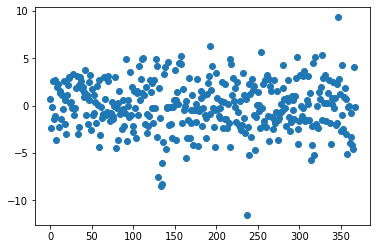

In [68]:
# Calculate residuals
y_hat = model_fit.predict(add_constant(X)) # Use fitted (=trained) model to calculate predictions (on same dataset model was fitted on)
plt.scatter(x=range(len(y)), y=y - y_hat)

In [69]:
import Assumptions as ass

Fitting linear regression

R^2: 0.49821310022236387 

Coefficients
-------------------------------------
Intercept: 8.541421768772848
age: -0.58
failures_mat: -0.99
absences_mat: 0.04
por_mean: 0.91
school_MS: 1.45
sex_M: 1.94
famsup_yes: -0.58
Mjob_teacher: -0.7

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


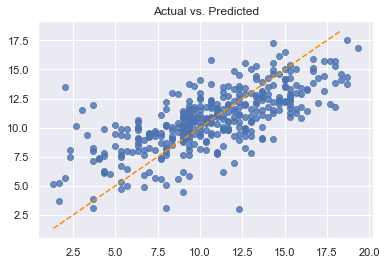

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with mat_mean


age            -0.174232
absences_mat   -0.019065
Name: mat_mean, dtype: float64


Parameters that are most likely FOLLOW linearity assumption and their correlation with mat_mean


failures_mat   -0.393156
por_mean        0.595787
Name: mat_mean, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


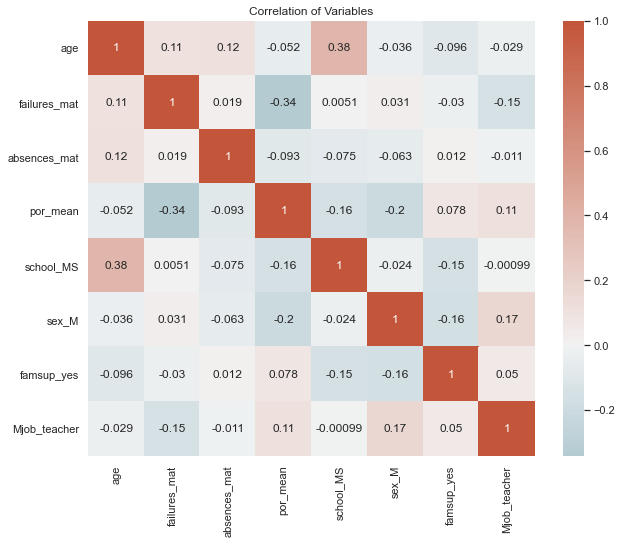

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
age: 37.87124758362139
por_mean: 28.82425191703451
famsup_yes: 2.8100027305005595
sex_M: 2.082085099275531
absences_mat: 1.5673902023492718
failures_mat: 1.346897546615172
school_MS: 1.3112894736706033
Mjob_teacher: 1.2701945465761513

2 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)

Assumption 3: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9172299118468379
Little to no autocorrelation 

Assumption satisfied

Assumpti

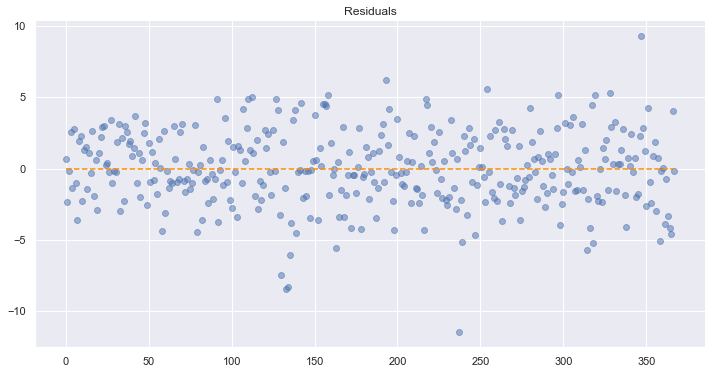

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 95.10190747582539,
 'pvalue for LM': 1.1044575994831326e-17,
 'F stats': 15.681992486015767,
 'pvalue for Fstats': 7.715555521681459e-20}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.2605537962403201
Residuals are normally distributed


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


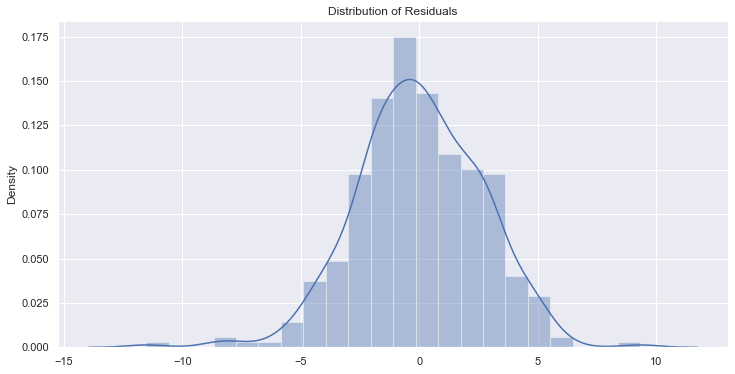


Assumption satisfied
Building a probability plot


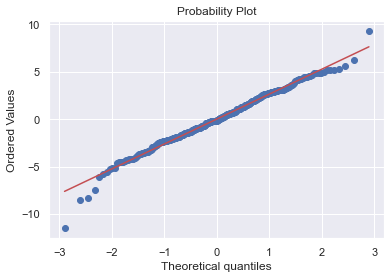


In your dataset you quite fat tails. You have 0.046 potential outliers (17 rows)


{'Satisfied': ['Autocorrelation', 'Normality'],
 'Potentially': ['Linearity',
  'Multicollinearity',
  'Autocorrelation',
  'Sub-Normality'],
 'Violated': []}

In [70]:
tester = ass.Assumption_Tester_OLS(X,y)
tester.run_all()